<a id="top"></a>
# Cloud Statistics

<hr>

# Notebook Summary

This notebook explores Landsat 7 and Landsat 8 Data Cubes and reports cloud statistics 
for selected regions within a cube. This is valuable information for performing analyses. 
For example, if there are extensive clouds for a season it may significantly impact the 
mosaic product or index values. Another example is that a user may want to find a single 
date when there are few clouds to assess land features.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platforms and Products](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Calculate the Cloud Coverage Percentage for Each Pixel](#calc_cloud_coverage)
* [Create a Table of Cloud Coverage Percentage for Each Date](#create_cloud_cov_table)
* [Create a Plot of Cloud Coverage Percentage for Each Date](#plot_cloud_cov)
* [Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period](#pct_clear_img)
* [Review an RGB Scene for a Selected Time Slice](#rgb_time_slice)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
# Enable importing of utilities.
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# These are the platforms (satellites) and products (datacube sets) 
# used for this demonstration.
use_Landsat7 = False
use_Landsat8 = True
platforms = []
products = []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_kenya')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_kenya')

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [5]:
from utils.data_cube_utilities.dc_load import get_overlapping_area
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_8 and product ls8_lasrc_kenya:
Time Extents: ['2013-04-12' '2020-01-19']

Overlapping Extents:
Latitude Extents: (-4.997106940467012, 5.996881030410326)
Longitude Extents: (32.98674340708594, 41.9828951536269)
Time Extents: ['2013-04-12', '2020-01-19']


**Visualize the available area**

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(full_lat, full_lon)

## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mombasa, Kenya
latitude = (-4.12, -3.975)
longitude = (39.55, 39.7) 

# Mau Forest - Western Kenya
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Dar es Salaam, Tanzania
# latitude = (-7.0, -6.7)
# longitude = (39.1, 39.4)

# Lake Sulunga, Tanzania
# latitude = (-6.2622, -5.8822) 
# longitude = (34.9802, 35.3602) 

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3109, -13.1197 )

# Vietnam
# latitude = (10.9358, 11.0358)
# longitude = (107.1899, 107.2899)

# Ghanas
# latitude = (5.5, 5.7)   # Accra
# longitude = (-0.4, 0.0) # Accra

# Time Period
time_extents = ('2016-01-01', '2016-12-31')

**Visualize the selected area**

In [8]:
display_map(latitude,longitude)

## <span id="calc_cloud_coverage">Calculate the Cloud Coverage Percentage for Each Pixel[&#9652;](#top)</span>

In [9]:
from utils.data_cube_utilities.dc_load import load_multiplatform

def build_cloud_coverage_table_landsat(products,
                                       platforms,
                                       latitude,
                                       longitude,
                                       time     = None,
                                       dc       = None,
                                       extra_band = 'green'):
    dc = dc if dc is not None else datacube.Datacube(app = "")
    
    load_params = dict(product = product,
                       platform = platform,
                       latitude = latitude,
                       longitude = longitude,
                       measurements = [extra_band, 'pixel_qa'])
    
    if time is not None: 
        load_params["time"] = time
    
    geo_data, clean_mask, masks = load_multiplatform(dc, platforms, products, load_params=load_params)
    del masks
    
    times = list(geo_data.time.values)
    scene_slice_list = list(map(lambda t: geo_data.sel(time = str(t)), times))
    
    clean_mask_list = [clean_mask.sel(time=str(time)).values for time in clean_mask.time.values]
    no_data_mask_list = list(map(lambda ds: (ds[extra_band]==-9999).values, scene_slice_list))
    # Calculate the percentage of all pixels which are not cloud.
    percentage_list = [clean_mask.mean()*100 for clean_mask in clean_mask_list]
    clean_pixel_count_list = list(map(np.sum, clean_mask_list))
    
    data = {"times": times,
            "clean_percentage": percentage_list,
            "clean_count": clean_pixel_count_list }
    
    return geo_data, pd.DataFrame(data=data, columns = ["times", "clean_percentage", "clean_count"])

In [10]:
extra_band = 'green'
landsat_dataset, coverage_table = build_cloud_coverage_table_landsat(products = products,
                                                                     platforms = platforms,
                                                                     latitude = latitude,
                                                                     longitude = longitude,
                                                                     time = time_extents,
                                                                     extra_band=extra_band)

## <span id="create_cloud_cov_table">Create a Table of Cloud Coverage Percentage for Each Date[&#9652;](#top)</span>

In [11]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,times,clean_percentage,clean_count
0,2016-01-10 07:31:41,0.000000,0
1,2016-01-26 07:31:41,66.564164,198714
2,2016-03-14 07:31:27,73.849529,220463
3,2016-03-30 07:31:17,82.208488,245417
4,2016-05-01 07:31:14,76.459317,228254
5,2016-05-17 07:31:11,48.215925,143939
6,2016-06-02 07:31:17,72.709945,217061
7,2016-06-18 07:31:20,12.799384,38210
8,2016-07-04 07:31:29,6.414431,19149
9,2016-07-20 07:31:36,54.874217,163816


## <span id="plot_cloud_cov">Create a Plot of Cloud Coverage Percentage for Each Date[&#9652;](#top)</span>

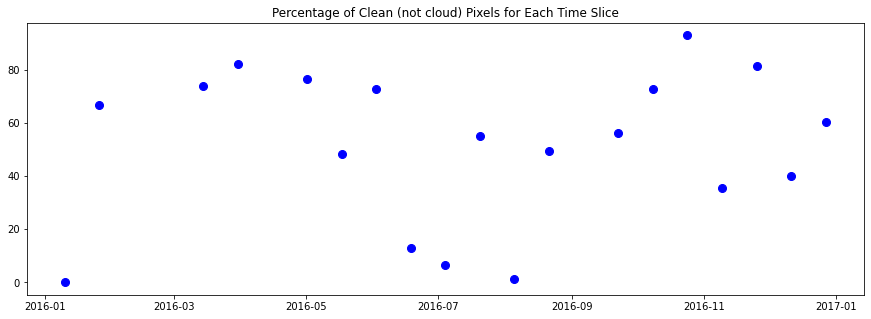

In [12]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["times"].values, coverage_table["clean_percentage"].values, 'bo', markersize=8)
plt.title("Percentage of Clean (not cloud) Pixels for Each Time Slice")
plt.show()

## <span id="pct_clear_img">Create an Image of the Percent of Clear Views Per Pixel for the Entire Time Period[&#9652;](#top)</span>

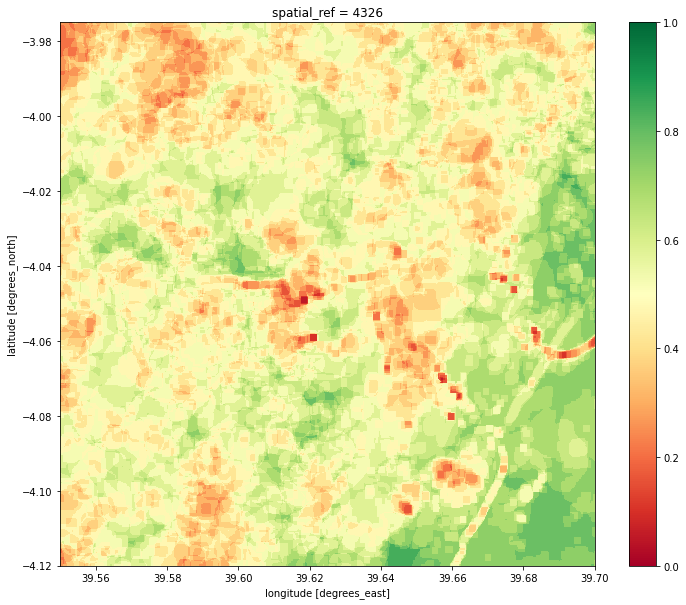

In [13]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.plotter_utils import create_gradient_color_map
from utils.data_cube_utilities.plotter_utils import xarray_imshow

# We are really plotting the fraction of times that are not no_data which are clear.
# This is done to account for regions filled with no_data  - such as when querying across path/rows.
data_mask = (landsat_dataset[extra_band] != -9999)
clean_mask = landsat_qa_clean_mask(landsat_dataset, platform)
merged_mask = clean_mask & data_mask
clear_and_data_per_px = merged_mask.sum(dim='time')
data_per_px = data_mask.sum(dim='time')
frac_clear_per_data_per_px = clear_and_data_per_px / data_per_px
num_cbar_ticks = 8 # The number of ticks to use for the colorbar.
quad_mesh = (frac_clear_per_data_per_px).plot(figsize=(12,10),cmap = "RdYlGn", vmin=0, vmax=1)
plt.show()

In [14]:
print("Percent of pixels with data: {:.2%}".format(data_mask.mean().values))
print("Percent of pixels that are clear: {:.2%}".format(clean_mask.mean().values))
print("Percent of pixels that are clear and have data: {:.2%}".format(merged_mask.mean().values))

Percent of pixels with data: 99.81%
Percent of pixels that are clear: 51.75%
Percent of pixels that are clear and have data: 51.75%


In [15]:
(frac_clear_per_data_per_px == 0).sum() / frac_clear_per_data_per_px.count()
print("Number of pixels which have no non-cloud data:", (frac_clear_per_data_per_px == 0).sum().values)
print("Total number of pixels:", frac_clear_per_data_per_px.count().values)

Number of pixels which have no non-cloud data: 0
Total number of pixels: 297972


## <span id="rgb_time_slice">Review an RGB Scene for a Selected Time Slice[&#9652;](#top)</span>

In [16]:
# Load the data to create an RGB image
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue']) 

<p style="color:red";><b>CHANGE INPUTS BELOW

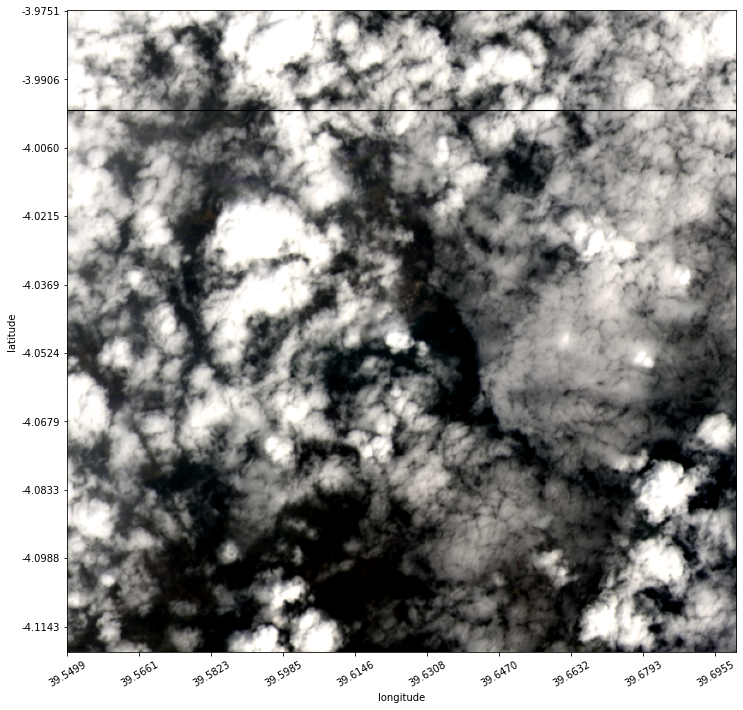

In [17]:
from utils.data_cube_utilities.dc_rgb import rgb
# CHANGE HERE >>>>>>>>>>>>>>

time_ind = 0 # The acquisition to select. The first acquisition has index 0.

# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE and cloud-shadows will be visible in BLACK

rgb(landsat_dataset.isel(time=time_ind), width=12)
plt.show()